In [206]:
%matplotlib inline
import math
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Input
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Dropout
from keras.layers import LSTM, GRU, Masking
from keras.optimizers import SGD, RMSprop, Adam

import datasets.data_reader


In [220]:
import keras
print(keras.__version__)

2.1.1


In [2]:
def train_test_split(X, Y, train_fraction=0.8, shuffle=False):
    N = len(Y)
    if shuffle == True:
        from random import shuffle
        idx = shuffle(np.arange(N))
        X = X[idx]
        Y = Y[idx]
   
    x_train = X[:math.ceil(N*train_fraction)]
    y_train = Y[:math.ceil(N*train_fraction)]
    x_test = X[math.ceil(N*train_fraction):]
    y_test = Y[math.ceil(N*train_fraction):]
    
    return x_train, y_train, x_test, y_test


# Part 1

Loaded clean data:
Data has shape = (30000, 457), contains 10 unique labels


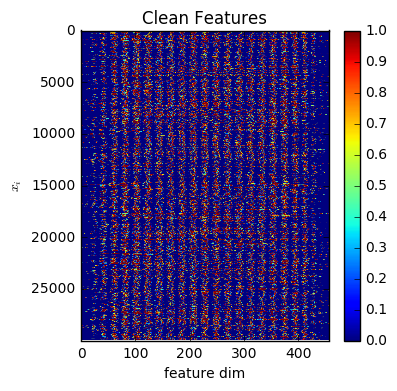

In [4]:
# Load data
x, y = datasets.data_reader.read_clean_dataset(summary=True)
y = datasets.data_reader.one_hot(y)
x_train, y_train, x_test, y_test = train_test_split(x, y)

feat_dim = x.shape[1]
out_dim = y.shape[1]



### Loss functions

In [160]:
def categorical_crossentropy(y_true, y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, 
                                                   logits=y_pred)
    return loss

# Using only basic tensorflow ops, implement the following functions
# TODO: cosine distance

def cosine_distance(y_true, y_pred):

    y_true_val = tf.sqrt(tf.reduce_sum(tf.matmul(y_true,tf.transpose(y_true)),axis=1))
    y_pred_val = tf.sqrt(tf.reduce_sum(tf.matmul(y_pred,tf.transpose(y_pred)),axis=1))
    denom =  tf.multiply(y_true_val,y_pred_val)
    num = tf.reduce_sum(tf.multiply(y_true,y_pred),axis=1)

    similarity = tf.div(num,denom)
    loss = 1-similarity
    return loss

# mean absolute error ^ n
def regression_error(y_true, y_pred, p=2):
    tmp = tf.pow((y_true,y_pred),p)
    tmp = tf.square(y_true-y_pred)
    loss = tf.reduce_mean(tmp)
    
    return loss

# TODO: hinge loss
def hinge_loss(y_true, y_pred):

    y_true = y_true*2 - 1
    y_pred = y_pred*2 - 1

    loss = tf.reduce_mean(tf.maximum(1. - y_true * y_pred, 0.), axis=-1)
    
    return loss

### Network architectures

In [191]:
# Network architectures
def build_mlp(model, num_nodes=64, num_layers=3, 
              activation='relu', ouput_activation='softmax'):
    """
    Builds a basic neural network in Keras.
    By default, assumes a multiclass classification 
    problem (softmax output).
    """
    model.add(Dense(num_nodes, activation=activation, 
                    input_shape=(feat_dim,)))
    for l in range(num_layers-1):
        model.add(Dense(num_nodes, activation=activation))
    model.add(Dense(out_dim, activation='softmax'))
    return model

# TODO: function to build a CNN
def build_cnn(model, input_shape ,out_dim,kernel_size=3,nb_outputs=10, nb_filter=4
              ,activation = 'relu', out_activation='softmax'):
    """
    Build a CNN to handle 1D sequences.
    """
    model.add(Dropout(0.5, input_shape=input_shape))
    model.add(Conv1D(filters=nb_filter, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())  
    model.add(Conv1D(filters=nb_filter, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(out_dim, activation=out_activation))   
    return model

# TODO: function to build an RNN
def build_rnn(model, out_dim,input_shape,lstm_shape = 100,out_activation='softmax'):
    """
    Build an RNN to handle 1D sequences.
    """ 
    model.add(LSTM(lstm_shape, input_shape=input_shape,return_sequences=False))
    model.add(Dense(out_dim,activation=out_activation))
    
    return model

### Train network and plot results

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 2s 91us/step - loss: 1.5946 - acc: 0.8827 - val_loss: 1.5429 - val_acc: 0.9233
Epoch 2/10
24000/24000 [==============================] - 2s 70us/step - loss: 1.5240 - acc: 0.9405 - val_loss: 1.5221 - val_acc: 0.9423
Epoch 3/10
24000/24000 [==============================] - 2s 63us/step - loss: 1.5069 - acc: 0.9565 - val_loss: 1.5183 - val_acc: 0.9455
Epoch 4/10
24000/24000 [==============================] - 1s 58us/step - loss: 1.4977 - acc: 0.9645 - val_loss: 1.5085 - val_acc: 0.9525
Epoch 5/10
24000/24000 [==============================] - 1s 56us/step - loss: 1.4914 - acc: 0.9707 - val_loss: 1.5055 - val_acc: 0.9568
Epoch 6/10
24000/24000 [==============================] - 1s 58us/step - loss: 1.4863 - acc: 0.9757 - val_loss: 1.5045 - val_acc: 0.9568
Epoch 7/10
24000/24000 [==============================] - 1s 57us/step - loss: 1.4831 - acc: 0.9787 - val_loss: 1.5081 - val_acc:

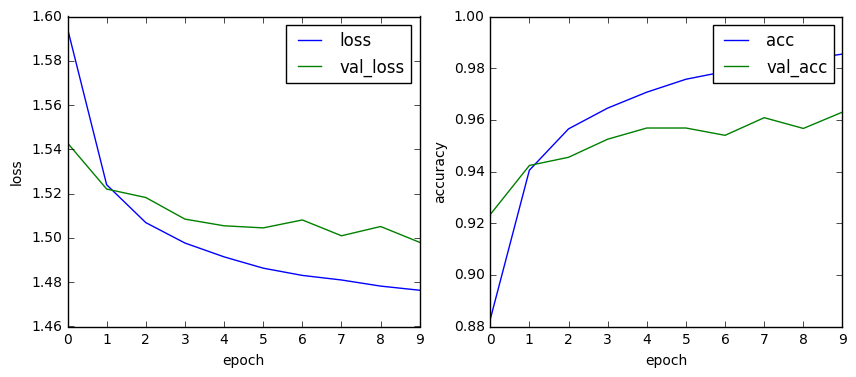

In [86]:
# Using an MLP to perform classification
num_nodes = 256
num_layers = 2
activation = 'relu'
batch_size = 64
epochs = 10

# Create model
model = Sequential()
model = build_mlp(model, num_nodes, num_layers, activation)


# Define optimizer and compile model
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=categorical_crossentropy, # <-- custom loss functions
              optimizer=rmsprop,
              metrics=['accuracy'])

# Train model
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    shuffle=True, 
                    validation_data=(x_test, y_test))

# Plot training history: loss as a function of epoch
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
for k in ['loss', 'val_loss']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend()

# Plot training history: accuracy as a function of epoch
ax = fig.add_subplot(122)
for k in ['acc', 'val_acc']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.legend()
plt.show()

# Part 2

Loaded corrupted data:
Data has shape = (30000, 457), average sequence length = 306.78


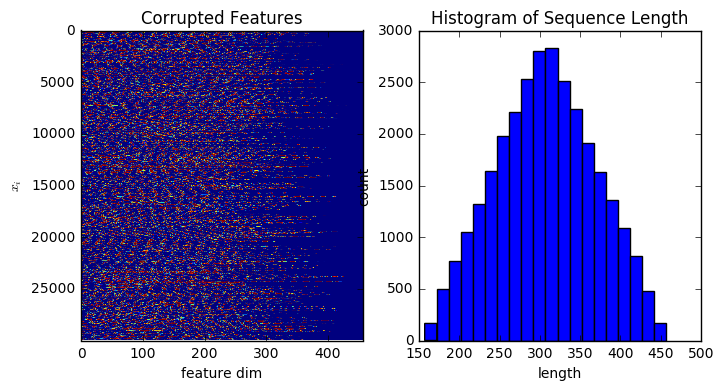

In [175]:
# Load corrupted dataset
x, x_len = datasets.data_reader.read_corrupted_dataset(summary=True)

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 4s 184us/step - loss: 0.1399 - acc: 0.6988 - val_loss: 0.0899 - val_acc: 0.7935
Epoch 2/10
24000/24000 [==============================] - 3s 141us/step - loss: 0.0882 - acc: 0.7866 - val_loss: 0.0855 - val_acc: 0.7922
Epoch 3/10
24000/24000 [==============================] - 3s 137us/step - loss: 0.0834 - acc: 0.7955 - val_loss: 0.0787 - val_acc: 0.8123
Epoch 4/10
24000/24000 [==============================] - 3s 140us/step - loss: 0.0819 - acc: 0.7992 - val_loss: 0.0785 - val_acc: 0.8073
Epoch 5/10
24000/24000 [==============================] - 3s 135us/step - loss: 0.0806 - acc: 0.8014 - val_loss: 0.0800 - val_acc: 0.8033
Epoch 6/10
24000/24000 [==============================] - 3s 135us/step - loss: 0.0802 - acc: 0.8020 - val_loss: 0.0777 - val_acc: 0.8100
Epoch 7/10
24000/24000 [==============================] - 3s 146us/step - loss: 0.0789 - acc: 0.8054 - val_loss: 0.0758 - v

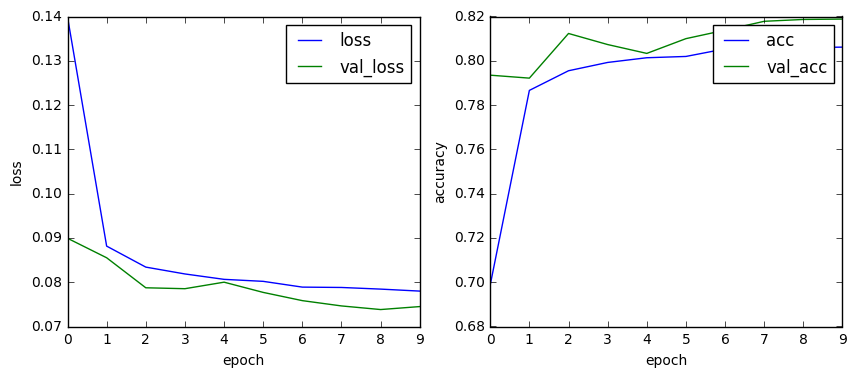

In [193]:
num_nodes = 256
num_layers = 2
activation = 'relu'
batch_size = 64
epochs = 10
input_shape = [feat_dim,1]

x_train_cnn = x_train.reshape([x_train.shape[0],x_train.shape[1],1])
x_test_cnn = x_test.reshape([x_test.shape[0],x_test.shape[1],1])

model = Sequential()

model = build_cnn(model, input_shape=input_shape,
                  out_dim = out_dim,kernel_size=3,nb_outputs=10, nb_filter=4
              ,activation = activation, out_activation='softmax')
# Define optimizer and compile model
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=categorical_crossentropy, # <-- custom loss functions
              optimizer=rmsprop,
              metrics=['accuracy'])

# Train model
history = model.fit(x_train_cnn, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    shuffle=True, 
                    validation_data=(x_test_cnn, y_test))

# Plot training history: loss as a function of epoch
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
for k in ['loss', 'val_loss']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend()

# Plot training history: accuracy as a function of epoch
ax = fig.add_subplot(122)
for k in ['acc', 'val_acc']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.legend()
plt.show()

In [215]:

from keras.layers import RNN


In [219]:
def build_rnn(model, out_dim,input_shape,units = 10,out_activation='softmax'):
    """
    Build an RNN to handle 1D sequences.
    """ 
    model.add(LSTM(units=units, input_shape=input_shape,return_sequences=False, activation='tanh'))
    model.add(Dense(out_dim,activation=out_activation))
    
    return model

num_nodes = 256
num_layers = 2
activation = 'relu'
batch_size = 64
epochs = 20
input_shape = [feat_dim,1]

x_train_cnn = x_train.reshape([x_train.shape[0],x_train.shape[1],1])
x_test_cnn = x_test.reshape([x_test.shape[0],x_test.shape[1],1])

model = Sequential()

model = build_rnn(model, out_dim,input_shape,units = 100,out_activation='softmax')
# Define optimizer and compile model
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adam = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
model.compile(loss=categorical_crossentropy, # <-- custom loss functions
              optimizer=rmsprop,
              metrics=['accuracy'])

# Train model
history = model.fit(x_train_cnn, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    shuffle=True, 
                    validation_data=(x_test_cnn, y_test))

# Plot training history: loss as a function of epoch
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
for k in ['loss', 'val_loss']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend()

# Plot training history: accuracy as a function of epoch
ax = fig.add_subplot(122)
for k in ['acc', 'val_acc']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.legend()
plt.show()

Train on 24000 samples, validate on 6000 samples
Epoch 1/20
24000/24000 [==============================] - 155s 6ms/step - loss: 2.2904 - acc: 0.1293 - val_loss: 2.2737 - val_acc: 0.1467
Epoch 2/20
24000/24000 [==============================] - 148s 6ms/step - loss: 2.2891 - acc: 0.1339 - val_loss: 2.2680 - val_acc: 0.2038
Epoch 3/20
24000/24000 [==============================] - 157s 7ms/step - loss: 2.2641 - acc: 0.1695 - val_loss: 2.2985 - val_acc: 0.1993
Epoch 4/20
24000/24000 [==============================] - 153s 6ms/step - loss: 2.2939 - acc: 0.1320 - val_loss: 2.3055 - val_acc: 0.0987
Epoch 5/20
24000/24000 [==============================] - 151s 6ms/step - loss: 2.2794 - acc: 0.1542 - val_loss: 2.2846 - val_acc: 0.1458
Epoch 6/20
 6464/24000 [=======>......................] - ETA: 1:45 - loss: 2.2352 - acc: 0.2073

KeyboardInterrupt: 

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 110s 5ms/step - loss: 2.2148 - acc: 0.1636 - val_loss: 2.1420 - val_acc: 0.2005
Epoch 2/10
24000/24000 [==============================] - 105s 4ms/step - loss: 2.1114 - acc: 0.2087 - val_loss: 2.0908 - val_acc: 0.2188
Epoch 3/10
24000/24000 [==============================] - 108s 4ms/step - loss: 2.1025 - acc: 0.2020 - val_loss: 2.1632 - val_acc: 0.2262
Epoch 4/10
24000/24000 [==============================] - 106s 4ms/step - loss: 2.0508 - acc: 0.2513 - val_loss: 2.0415 - val_acc: 0.3047
Epoch 5/10
24000/24000 [==============================] - 100s 4ms/step - loss: 2.0195 - acc: 0.3023 - val_loss: 2.0083 - val_acc: 0.3208
Epoch 6/10
24000/24000 [==============================] - 104s 4ms/step - loss: 2.0141 - acc: 0.3094 - val_loss: 2.0042 - val_acc: 0.3142
Epoch 7/10
24000/24000 [==============================] - 102s 4ms/step - loss: 2.0047 - acc: 0.3045 - val_loss: 2.0230 - v

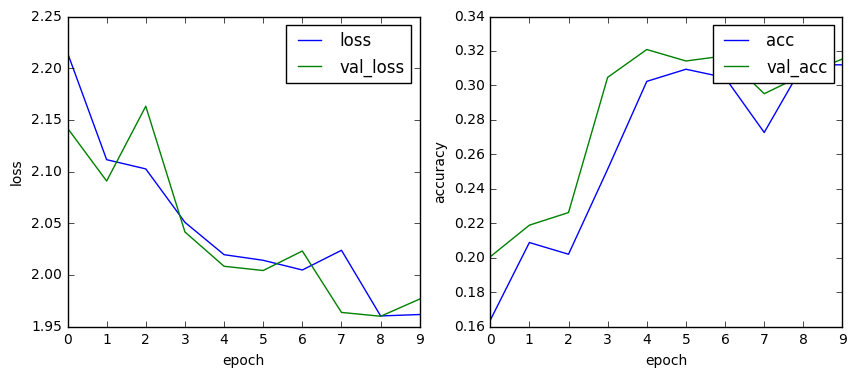

In [201]:
'''prediction of RNN'''
def build_rnn(model, out_dim,input_shape,units = 10):
    """
    Build an RNN to handle 1D sequences.
    """ 
    model.add(LSTM(units=units, input_shape=input_shape,return_sequences=False))
    #model.add(Dense(out_dim,activation=out_activation))
    
    return model

num_nodes = 256
num_layers = 2
activation = 'relu'
batch_size = 64
epochs = 10
input_shape = [feat_dim,1]

x_train_cnn = x_train.reshape([x_train.shape[0],x_train.shape[1],1])
x_test_cnn = x_test.reshape([x_test.shape[0],x_test.shape[1],1])

model = Sequential()

model = build_rnn(model, out_dim,input_shape,units = 10,out_activation='softmax')
# Define optimizer and compile model
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=categorical_crossentropy, # <-- custom loss functions
              optimizer=rmsprop,
              metrics=['accuracy'])

# Train model
history = model.fit(x_train_cnn, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    shuffle=True, 
                    validation_data=(x_test_cnn, y_test))

# Plot training history: loss as a function of epoch
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
for k in ['loss', 'val_loss']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend()

# Plot training history: accuracy as a function of epoch
ax = fig.add_subplot(122)
for k in ['acc', 'val_acc']:
    ax.plot(history.history[k], label=k)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.legend()
plt.show()